# **Nonlinear Diffusion-Reaction Equation**

Created by Shanghui Huang (shuang7@nd.edu)

This example was adapted from:

McClarren, Ryan G (2018). Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers, Chapter 6: Adjoints-Based Local Sensitivity Analysis, Springer, https://doi.org/10.1007/978-3-319-99525-0_6

And special acknowledgement to *Han Gao* for a fruitful discussion

## An Overview
This chapter introduces an adjoint-based method to compute the local sensitivity of a QoI against a parameter. In this method, adjoints gives information of perturbed quantity with only one solve of the forward system and one solve of the adjoint equations.

Take the steady ADR equation for example: 
\begin{equation}
v\frac{\partial u}{\partial x} - \omega \frac{\partial ^2 u}{\partial x^2} + \kappa u = q
\end{equation}
the operator $L$ is defined as:
\begin{equation}
L = v\frac{\partial}{\partial x} - \omega \frac{\partial ^2}{\partial x^2} + \kappa
\end{equation}
Then the adjoints satisfies:
\begin{equation}
(Lu,u^{\ast})=(u,L^{\ast}u^{\ast})
\end{equation}
and
\begin{equation}
L^{\ast}u^{\ast} = w
\end{equation}
After a series of mathematical derivations, we can calculate the local sensitivities:
\begin{equation}
\frac{\partial Q}{\partial \theta} = (\frac{\partial q}{\partial \theta},u^{\ast}) + (u,\frac{\partial w}{\partial \theta}) - (\frac{\partial L}{\partial \theta}u,u^{\ast})
\end{equation} 

## Example of nonlinear diffusion-reaction equation

Solving nonlinear diffusion-reaction equation:
\begin{equation}
F(u,\dot{u}) = \rho\dot{u}-\omega\frac{\partial^2u^4}{\partial x^2} + \kappa u^4 - S
\end{equation}
in which 
\begin{equation}
\kappa (x) =
\begin{cases}
\kappa_h, & 1 \le x \lt 1.5 \\
\kappa_l, & otherwise
\end{cases}
\end{equation}
\begin{equation}
\S(x) = 
\begin{cases}
q, & 0.5 \le x \le 1.5 \\
0, & otherwise
\end{cases}
\end{equation}
with nominal values 
\begin{equation}
\rho = 1, \omega = 0.1, \kappa _l = 0.1 \kappa _h =2, q = 1
\end{equation}

## Codes

In [6]:
!pip install --upgrade pyDOE
!pip install tabulate

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=eae884fee2b8e02ed0591f4026fbd6d99f8c3937a2ef7b62e330bfd5bc6672e9
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.integrate as integrate
from scipy.stats import gamma
import math
from scipy.stats.distributions import norm
from scipy import stats
from pyDOE import *
%matplotlib inline

In [8]:
def ADRSource(Lx, Nx, Source, omega, v, kappa):
    #Solves the diffusion equation with Generalized Source
    A = sparse.dia_matrix((Nx,Nx),dtype="complex")
    dx = Lx/Nx
    i2dx2 = 1.0/(dx*dx)
    #fill diagonal of A
    A.setdiag(2*i2dx2*omega + np.sign(v)*v/dx)
    #fill off diagonals of A
    A.setdiag(-i2dx2*omega[1:Nx] + 
              0.5*(1-np.sign(v[1:Nx]))*v[1:Nx]/dx,1)
    A.setdiag(-i2dx2*omega[0:(Nx-1)] - 
              0.5*(np.sign(v[0:(Nx-1)])+1)*v[0:(Nx-1)]/dx,-1)
    #solve A x = Source
    Solution = linalg.spsolve(A,Source)
    Q = integrate.trapz(Solution*kappa,dx=dx)
    return Solution, Q

###A function calculating solution $u$

In [9]:
def run_calc(Lx, Nx, rho, Source, omega, v, 
             kappa, dt, steps,
             tmin,tmax,xmin,xmax, IC):
    dx = Lx/Nx
    assert IC.size==Nx
    irho = 1/rho
    dt2 = dt/2
    idx2 = 1/dx**2
    solution = np.zeros((Nx+2,steps+1))
    solution[1:Nx+1,0] = 1.0*IC #copy IC
    xs = np.linspace(-dx/2,Lx+dx/2,Nx+2)
    Q = 0
    for step in range(steps):
        #predictor
        pred = solution[:,step]*1.0
        
        pred[1:Nx+1] = (pred[1:Nx+1]-irho*kappa*dt2*pred[1:Nx+1]**4 +
                        irho*dt2*Source +
                        irho*dt2*omega*idx2*(pred[2:Nx+2]**4 - 2*pred[1:Nx+1]**4 + pred[0:Nx]**4))
        
        #corrector
        solution[1:Nx+1,step+1] = (solution[1:Nx+1,step]-irho*kappa*dt*pred[1:Nx+1]**4 + 
                                   irho*dt*Source +
                                   irho*dt*omega*idx2 * (pred[2:Nx+2]**4 - 2*pred[1:Nx+1]**4 + pred[0:Nx]**4))
        if ((step+1)*dt >= tmin) and ((step+1)*dt <= tmax):
            Q += np.sum(dt*solution[1:Nx+1,step][(xs[1:Nx+1]>=xmin)*(xs[1:Nx+1]<=xmax)]*
                        kappa[(xs[1:Nx+1]>=xmin)*(xs[1:Nx+1]<=xmax)]*dx)
    return solution,Q,xs

### Setting up the nonlinear diffusion-reaction equation

In [10]:
#set up simple advection problem
Lx = 2
Nx = 200
dx = Lx/Nx
dt = dx**2
#print('Timestep = ',dt)
tfinal = 2
numsteps = math.ceil(tfinal/dt)
xs = np.linspace(dx/2,Lx-dx/2,Nx)
Source_func = lambda x, q:  (x>0.25*Lx)*(x<0.75*Lx)*q
kappa_func = lambda x, kappal, kappah: kappah + (kappal-kappah)*(x>0.5*Lx)*(x<0.75*Lx)
#print('Number of steps = ', numsteps)
IC = np.zeros(Nx)
IC[Nx//4:3*Nx//4] = 1*0
source = IC*0
source[Nx//4:3*Nx//4] = 10

omega_nom = .1
v_nom = 0.0
kappal_nom = 0.1
kappal_var = 8.511570e-6
kappah_nom = 2
kappah_var = 0.002778142
q_nom = 1
q_var = 7.062353e-4
rho = 1.0

sol,Q,xs2 = run_calc(Lx, Nx, rho, Source_func(xs,1), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
#print(Q)
xs3 = xs2
#plt.plot(xs2,sol[:,numsteps])

### A function calculating adjoint solution $u^{\ast}$

In [11]:
def run_adjoint_calc(Lx, Nx, rho, Source, omega, v, kappa, dt, steps,tmin,tmax,xmin,xmax, IC, forward):
    dx = Lx/Nx
    assert IC.size==Nx
    dt2 = dt/2
    irho = 1/rho
    solution = np.zeros((Nx+2,steps+1))
    solution[1:Nx+1,steps] = 1.0*IC #copy IC
    xs = np.linspace(-dx/2,Lx+dx/2,Nx+2)
    Q = 0
    ks = kappa*(xs[1:Nx+1]>=xmin)*(xs[1:Nx+1]<=xmax)
    for step in range(steps-1,-1,-1):
        #predictor
        pred = solution[:,step+1]*1.0
        pred[1:Nx+1] = (pred[1:Nx+1]*(1- irho*4*kappa*dt2*forward[1:Nx+1,step]**3) + 
                        irho*dt2*ks*((step+1)*dt >= tmin)*((step+1)*dt <= tmax) +
                        irho*4*dt2*omega/(dx**2)*forward[1:Nx+1,step]**3 * (pred[2:Nx+2]-2*pred[1:Nx+1] + pred[0:Nx]))  
                        
        
        #corrector
        solution[1:Nx+1,step] = (solution[1:Nx+1,step+1]-irho*4*kappa*dt*pred[1:Nx+1]*forward[1:Nx+1,step]**3 + 
                                 irho*dt*ks*((step+1)*dt >= tmin)*((step+1)*dt <= tmax)+
                                 irho*4*dt*omega/(dx**2)*forward[1:Nx+1,step]**3 * (pred[2:Nx+2]-2*pred[1:Nx+1] + pred[0:Nx])) 
    return solution,xs

In [12]:
sol_adj,xs2 = run_adjoint_calc(Lx, Nx,rho, Source_func(xs,1), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom), dt, numsteps, 1.8,tfinal,1.5,1.9,IC*0, sol)

output = np.vstack([xs2,sol[:,numsteps], sol_adj[:,round(1.8/dt)]]).transpose()
np.savetxt('nonlindr_foradj.csv', output, delimiter=',')

### Results of foward and adjoint solutions

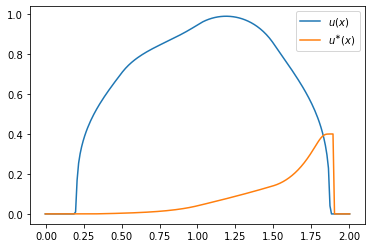

In [16]:
plt.plot(xs3,sol[:,numsteps],label=r'$u(x)$')
plt.plot(xs2,sol_adj[:,0],label=r'$u^{\ast}(x)$')
plt.legend()

### Compare sensitivities to parameters resulted from finite differences and the adjoint methodology: $\rho$, $\omega$,$\kappa_l$,$\kappa_h$,$q$ respectively

In [ ]:
sens_adj = np.zeros(5)
sens_for = np.zeros(5)
#rho sens
delta = 1.0e-6
sol_pert,Q_v,xs2 = run_calc(Lx, Nx, rho+delta,Source_func(xs,1), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom), dt, numsteps,1.8,tfinal,1.5,1.9,IC)
sens_for[0] = (Q_v-Q)/delta

dudx = np.zeros((Nx+2,numsteps+1))
dudx[:,0:(numsteps)] = (sol[:,1:(numsteps+1)] - sol[:,0:(numsteps)])/(dt)
#dudx[Nx-1] = (0-sol[Nx-2])/(2*dx)
#dudx[0,:] = (sol[0,:]-0)/(dx)
sens_adj[0] = np.sum(-dudx*sol_adj*dx*dt)
print(sens_for[0],sens_adj[0])

-0.09947973321489112 -0.09948429352239387


In [ ]:
#omega sens
delta = 1.0e-6
sol_pert,Q_v,xs2 = run_calc(Lx, Nx,rho, Source_func(xs,1), omega_nom+delta, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
sens_for[1] = (Q_v-Q)/delta

dudx2 = np.zeros((Nx+2,numsteps+1))
dx = Lx/Nx
dudx2[1:(Nx+1),:] = (sol[0:Nx,:]**4 - 2*sol[1:(Nx+1),:]**4 + sol[2:(Nx+2),:]**4)/(dx**2)
sens_adj[1] = np.sum(dudx2*sol_adj*dx*dt)
print(sens_for[1],sens_adj[1])

0.28897547187101136 0.288993704223791


In [ ]:
low_area = lambda x: (x>0.5*Lx)*(x<0.75*Lx)
low_area_abs = lambda x: (x>1.5)*(x<1.9)*(x>0.5*Lx)*(x<0.75*Lx)
delta = 1e-6
sens_adj[2] = np.sum(dx*(sol[low_area_abs(xs2),:])*dt)
sens_adj[2] += np.sum(-sol[low_area(xs2),:]**4*sol_adj[low_area(xs2),:]*dt*dx)
sol_pert,Q_v,xs2 = run_calc(Lx, Nx,rho, Source_func(xs,1), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom+delta, kappah_nom), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
sens_for[2] = (Q_v-Q)/delta
print(sens_for[2],sens_adj[2])

-0.03022436832755826 -0.030226185976361303


In [ ]:
delta = 1e-6
high_area_abs = lambda x: (x>1.5)*(x<1.9)*(x>1.75*Lx)+(x>1.5)*(x<1.9)*(x<1.5*Lx)
high_area = lambda x: (x<0.5*Lx)+(x>0.75*Lx)
ts = np.linspace(0,tfinal,numsteps+1)
intime = lambda t: (t>=1.8)*(t<=tfinal)*1+0
sens_adj[3] = np.sum(dx*(sol[high_area_abs(xs2),:])*intime(ts)*dt)
sens_adj[3] += np.sum(-sol[high_area(xs2),:]**4*sol_adj[high_area(xs2),:]*dt*dx)
sol_pert,Q_v,xs2 = run_calc(Lx, Nx, rho, Source_func(xs,1), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom+delta), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
sens_for[3] = (Q_v-Q)/delta
print(sens_for[3],sens_adj[3])

0.03215599961303717 0.03215767861360508


In [ ]:
sens_adj[4] = np.sum(dx*sol_adj[(xs2>0.25*Lx)*(xs2<0.75*Lx),:]*dt)
sol_pert,Q_v,xs2 = run_calc(Lx, Nx, rho,Source_func(xs,1+delta), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
sens_for[4] = (Q_v-Q)/delta
print(sens_for[4],sens_adj[4])

0.09638222440988553 0.09638749590621687


In [ ]:
output = np.vstack([sens_for,sens_adj,np.abs(sens_for-sens_adj)/np.abs(sens_for)/1e-5]).transpose()
output1 = [["Parameters" ,'Finite Difference','Adjoint Estimate','Abs. Difference (10^-5)'],['\N{GREEK SMALL LETTER RHO}',output[0,0],output[0,1],output[0,2]],['\N{GREEK SMALL LETTER omega}',output[1,0],output[1,1],output[1,2]],['\N{GREEK SMALL LETTER kappa}\u2097',output[2,0],output[2,1],output[2,2]],['\N{GREEK SMALL LETTER kappa}\u2095',output[3,0],output[3,1],output[3,2]],['q',output[4,0],output[4,1],output[4,2]]]
import tabulate
print(tabulate.tabulate(output1, tablefmt="Latex", floatfmt=".5f"))



----------  --------------------  ---------------------  -----------------------
Parameters  Finite Difference     Adjoint Estimate       Abs. Difference (10^-5)
ρ           -0.09947973321489112  -0.09948429352239387   4.584157350819606
ω           0.28897547187101136   0.288993704223791      6.309308074348965
κₗ          -0.03022436832755826  -0.030226185976361303  6.013852079040496
κₕ          0.03215599961303717   0.03215767861360508    5.221422403645427
q           0.09638222440988553   0.09638749590621687    5.469365708888537
----------  --------------------  ---------------------  -----------------------


### Comparison for Reliability

In [17]:
means = [rho, omega_nom, kappal_nom, kappah_nom, q_nom]
varmat = np.zeros((5,5))
#fill in diagonal
corrmat = np.ones((5,5))
corrmat[0,:] = (1,.1,-0.05,0,0)
corrmat[1,:] = (.1,1,-.4,.3,.5)
corrmat[2,:] = (-0.05,-.4,1,.2,0)
corrmat[3,:] = (0,.3,0.2,1,-.1)
corrmat[4,:] = (0,.5,0,-.1,1)
print(corrmat-corrmat.transpose())
print(corrmat)


samps = 10**3
test = norm.cdf(np.random.multivariate_normal(np.zeros(5), corrmat, samps))

def gen_samps(samps,test):
    #rho will have v_nom = 1 v_var = .1 which makes alpha = 10 beta = 10 or theta = 1/10
    vsamps = gamma.ppf(test[:,0], a = 100, scale = 1/100)
    print(np.mean(vsamps), np.var(vsamps), np.std(vsamps))
    #plt.hist(vsamps)

    #omega will have  omega_nom = .1, var = .1 which makes alpha = 100 beta = 5, theta = 1/5
    omegasamps = gamma.ppf(test[:,1], a = 100, scale = 1/2000)
    print(np.mean(omegasamps), np.var(omegasamps), np.std(omegasamps))
    #plt.hist(omegasamps)

    #kappa_l will have kappa_l = 0.1 var = (0.01)^2 this makes alpha = 100 and theta = 1/1000
    kappalsamps = gamma.ppf(test[:,2], a = 100, scale = 1/1000)
    print(np.mean(kappalsamps), np.var(kappalsamps), np.std(kappalsamps))
    #plt.hist(kappalsamps)

    #kappa_h will have kappa_h = 2 var = .04 this makes alpha = 100 and theta = 1/50
    kappahsamps = gamma.ppf(test[:,3], a = 100, scale = 1/50)
    print(np.mean(kappahsamps), np.var(kappahsamps), np.std(kappahsamps))
    #plt.hist(kappahsamps)

    #q will have q = 1 var = 0.01 this makes alpha = 100 and theta = 1/100
    qsamps = gamma.ppf(test[:,4], a = 100, scale = 1/100)
    print(np.mean(qsamps), np.var(qsamps),np.std(qsamps))
    #plt.hist(qsamps)
    
    return vsamps,omegasamps,kappalsamps,kappahsamps,qsamps
vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test)

var_list = [vsamps,omegasamps,kappalsamps,kappahsamps,qsamps]
cormat_emp = np.zeros((5,5))
tmp = np.vstack((var_list[0],var_list[1],var_list[2],var_list[3],var_list[4]))
cormat_emp = np.cov(tmp)
sens = np.array([-0.0994797332704,0.288975471816,-0.0302243683414,0.0321559995853,0.096382224285])
print(cormat_emp, np.dot(sens,np.dot(cormat_emp,sens)))

print(run_calc(Lx, Nx, np.mean(vsamps), Source_func(xs,np.mean(qsamps)), np.mean(omegasamps), v_nom, 
                 kappa_func(xs,np.mean(kappalsamps), np.mean(kappahsamps)), dt, numsteps, 1.8,tfinal,1.5,1.9,IC))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[ 1.    0.1  -0.05  0.    0.  ]
 [ 0.1   1.   -0.4   0.3   0.5 ]
 [-0.05 -0.4   1.    0.2   0.  ]
 [ 0.    0.3   0.2   1.   -0.1 ]
 [ 0.    0.5   0.   -0.1   1.  ]]
0.9922977210635758 0.010566538975926807 0.10279367186712812
0.05021961567550527 2.4905472687980364e-05 0.004990538316452481
0.10022954616433 9.927306454631912e-05 0.009963586931738946
2.015168892538771 0.04332608207069289 0.20814918224843665
1.0005110913540498 0.010210495960569357 0.10104699877071736
[[ 1.05771161e-02  5.54030481e-05 -3.96931120e-05  3.54289587e-04
  -6.92092191e-05]
 [ 5.54030481e-05  2.49304031e-05 -2.20896335e-05  2.87449455e-04
   2.44165203e-04]
 [-3.96931120e-05 -2.20896335e-05  9.93724370e-05  3.48562887e-04
   7.25861375e-06]
 [ 3.54289587e-04  2.87449455e-04  3.48562887e-04  4.33694515e-02
  -2.45241544e-03]
 [-6.92092191e-05  2.44165203e-04  7.25861375e-06 -2.45241544e-03
   1.02207167e-02]] 0.0002456804140

In [18]:
outputs=np.zeros(samps)
for i in range(samps):
    sol,Q,xs2 = run_calc(Lx, Nx, vsamps[i], Source_func(xs,qsamps[i]), omegasamps[i], v_nom, 
                 kappa_func(xs,kappalsamps[i], kappahsamps[i]), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
    outputs[i] = Q


In [ ]:
print(np.var(outputs),outputs,vsamps)

np.savetxt("nonlinear_ref_adr.csv", outputs, delimiter=",")

(array([ 12.,  41., 121., 210., 245., 199., 108.,  49.,  13.,   2.]),
 array([0.03171055, 0.04013366, 0.04855677, 0.05697988, 0.06540299,
        0.0738261 , 0.08224921, 0.09067232, 0.09909542, 0.10751853,
        0.11594164]),
 <a list of 10 Patch objects>)

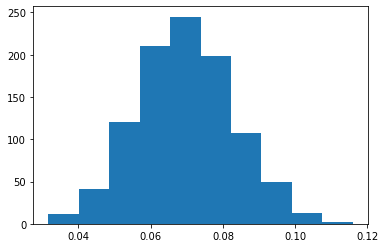

In [20]:
plt.hist(outputs)

In [ ]:
#lhd will have the values in 0 to 1
samps =10**3
lhd = lhs(5, samples=samps)
#now i need to turn these into samples from N(0,Corrmat)
#do cholesky fact
chol = np.linalg.cholesky(corrmat)

lhs_unif = np.zeros((samps,5))
for i in range(samps):
    lhs_unif[i,:] = np.dot(chol,norm.ppf(lhd[i,:]))
test_lhs = norm.cdf(lhs_unif)

vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test_lhs)

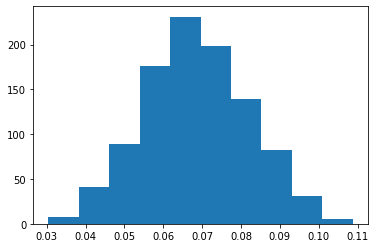

0.06851216544161239 0.09131389762764693 0.046238313965240176 0.013419289882262094 -0.2772953252193724 0.07380452982344808


In [ ]:
QLHS = np.zeros(samps)
outputs_LHS=np.zeros(samps)
for i in range(samps):
    sol,QLHS[i],xs2 = run_calc(Lx, Nx, vsamps[i], Source_func(xs,qsamps[i]), omegasamps[i], v_nom, 
                 kappa_func(xs,kappalsamps[i], kappahsamps[i]), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
    outputs_LHS[i] = QLHS[i]


plt.hist(QLHS)
plt.show()
print(np.mean(QLHS),stats.scoreatpercentile(QLHS,95),stats.scoreatpercentile(QLHS,5),np.std(QLHS), 
      stats.kurtosis(QLHS), stats.skew(QLHS))
#print(np.mean(Qs),stats.scoreatpercentile(Qs,95) ,stats.scoreatpercentile(Qs,5),np.std(Qs), stats.kurtosis(Qs), stats.skew(Qs))

np.savetxt("nonlinear_ref_adr_LHS.csv", outputs_LHS, delimiter=",")

